## Lecture 1 - $18^{th}$ November 2024

This notebook presentation is part of my lecture material for the Advanced Quantum Mechanics course at the University of Trieste. It contains a general introduction to Qiskit and Pennylane

**Michele Grossi**, Coordinator of Hybrid Quantum Computing Infrastracture and Algorithms @ CERN


# Quantum Frameworks for near terms computation: Qiskit and Pennylane
<br>
<br>
You can find a copy of this presentation at

https://github.com/grossiM/LAB_Quantum_Computation24/tree/main

michele.grossi@cern.ch

### Installing Qiskit 1.0.X and Pennylane

Anaconda or a pyenv is recommended to manage all dependencies.
The file environment.yml contains the required libraries and can be installed in this way:

*Command:* `conda env create -f environment.yml`


In [1]:
# Install libraries if needed (uncomment if necessary)

import qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
import pennylane as qml
from pennylane import numpy as np

/Users/sebastianopian/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
print("Qiskit version:", qiskit.__version__)
print("PennyLane version:", qml.__version__)

Qiskit version: 1.2.4
PennyLane version: 0.38.0


### 1. Introduction to Qiskit and PennyLane
##### Overview of Each Library

- **Qiskit**: Developed by IBM, Qiskit provides tools for designing, simulating, and executing quantum circuits on IBM quantum hardware (see https://docs.quantum.ibm.com/guides and https://www.ibm.com/quantum/ecosystem).
- **PennyLane**: Created by Xanadu, PennyLane is a quantum machine learning library designed for hybrid quantum-classical computations. PennyLane supports backends like Qiskit, Cirq, and others, making it versatile for research in quantum machine learning (QML).

| Features | Qiskit   | Pennylane   |
|------|------|------|
|   Primary Focus  | Circuit-based computations| Quantum machine learning, VQAs  |
|ML Integration  | Not specialized for ML| Direct PyTorch and TensorFlow support  |
|   Parameterized Gates  | 	Supported with Parameter API| Seamlessly integrates parameterized gates  |
|   Supported Backends  | IBM hardware, QASM simulators| Multiple (Qiskit, Cirq, Rigetti, etc.)  |

							

#### Simple Circuit Comparison

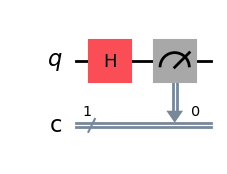

In [3]:
# Qiskit Example: Single-Qubit Circuit with H-Gate
qc = QuantumCircuit(1, 1)
qc.h(0)
qc.measure(0, 0)
qc.draw(output='mpl')


In [4]:
# PennyLane Example: Single-Qubit Circuit with H-Gate
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def simple_circuit():
    qml.Hadamard(wires=0)
    return qml.probs(wires=0)

simple_circuit()


tensor([0.5, 0.5], requires_grad=True)

#### Circuits vs quantum functions

In most quantum SDKs there are dedicated primitives that implement *Quantum circuits*. You may recall that indeed, this was the case for IBM's Qiskit, where quantum algorithms are realized as specific circuit objects:

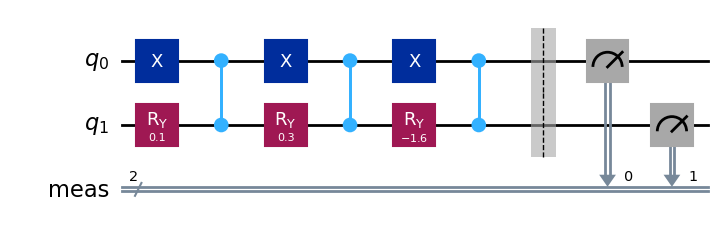

In [5]:
from qiskit import QuantumCircuit
import pennylane as qml
from pennylane import numpy as np

#import numpy as np
thetas = np.array([0.1, 0.3, -1.6])

qiskit_circ = QuantumCircuit(2)

for t in thetas:
    qiskit_circ.x(0)
    qiskit_circ.ry(t.item(), 1)
    qiskit_circ.cz(0, 1)

qiskit_circ.measure_all()

qiskit_circ.draw("mpl")

While this approach is straight-forward to understand, makes handling parameterizations more cumbersome than really needed. What if I want to change the numerical value of $\theta$? This would either require the creation of a new circuit, or usage of more complicated abstractions, which can make our code hard to develop. We will see it in the next lecture. 

In **Qiskit**, circuits are built with gate methods `(qc.h, qc.measure)`, while in **PennyLane**, a circuit is defined as a Python function annotated with `@qml.qnode`.

A more natural approach for this specific use-case is to implement circuits as special kinds of **functions**, which are called quantum functions. In pennylane, quantum functions are implemented simply as Python functions, and evaluation of quantum functions are linked to the estimation of the circuit output specified during the definition.

#### Devices and Quantum Nodes

Quantum functions alone, just as quantum circuits, are only an abstract description of the quantum algorithm, and are not enough to acutally perform computations. For that, we need *devices*. In pennylane, a device represents an entity able to execute quantum functions, be it a simulator or a real quantum device.

Thanks to the large amout of interfaces and plugins that this environment provides (https://pennylane.ai/plugins/) code written in pennylane can run almost on all quantum simulator (ideal, noisy, tensor-network based etc..) and even real devices (including IBM public machines!). Of course, each device has its own peculiarity and must be configured with care. 

Today we'll focus on the simplest one, i.e. `deafult.qubit`.

## 2. Create Bell state

A *Bell state*, also known as an *EPR pair* (Einstein-Podolsky-Rosen pair), is a specific two-qubit state which is maximally entangled. Entanglement is another important phenomenon, which characterizes a quantum system, where the quantum states of two or more particles become correlated in such a way that the state of one particle cannot be described independently of the other, regardless of the distance between them.

On the quantum circuit, Bell state can be created by applying a set of quantum states to the initial state $|00\rangle$ :

$$
\begin{align}
& \text{Initial State} = |00\rangle \nonumber \\ \to & H_0|00\rangle  = \frac{1}{\sqrt{2}} (|00\rangle + |10\rangle) \nonumber \\
\to & CNOT_{01}  \frac{1}{\sqrt{2}} (|00\rangle + |10\rangle) = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)
\end{align}$$  

#### Pennylane

In [6]:
import pennylane as qml
from pennylane import numpy as np

# Define a device with 2 qubits
dev = qml.device("default.qubit", wires=2)

# Define the quantum node
@qml.qnode(dev)
def bell_state_circuit():
    # Create the Bell state
    qml.Hadamard(wires=0)         # Apply Hadamard gate on the first qubit
    qml.CNOT(wires=[0, 1])        # Entangle with a CNOT gate
    
    # Return the state vector
    return qml.state()

# Execute the circuit
state = bell_state_circuit()

# Display the result
print("State vector of the Bell state:")
print(state)


State vector of the Bell state:
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


**Simulating Measurement Outcomes**

In [7]:
from collections import Counter

# Define a device with 2 qubits and set shots
num_shots = 1000
dev = qml.device("default.qubit", wires=2, shots=num_shots)

# Define a quantum node to measure in the computational basis
@qml.qnode(dev)
def bell_state_measurement():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.sample(wires=[0, 1])  # Measure both qubits

# Execute the circuit
samples = bell_state_measurement()

# Count the outcomes
counts = Counter(map(tuple, samples))
print(f"Measurement counts after {num_shots} shots:")
print(counts)



Measurement counts after 1000 shots:
Counter({(tensor(0, requires_grad=True), tensor(0, requires_grad=True)): 529, (tensor(1, requires_grad=True), tensor(1, requires_grad=True)): 471})


#### Qiskit

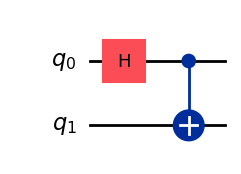

In [8]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
 
# Create a new circuit with two qubits (first argument) and two classical
# bits (second argument)
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

You can use local testing mode with simulators from` Qiskit Aer`, which provides higher-performance simulation that can handle larger circuits and custom noise models. It also supports `Clifford` simulation mode, which can efficiently simulate Clifford circuits with a large number of qubits.

In [9]:
from qiskit_aer import AerSimulator
# Print all the available quantum simulators
simulator = AerSimulator()

In [10]:
simulator.available_methods()

('automatic',
 'statevector',
 'density_matrix',
 'stabilizer',
 'matrix_product_state',
 'extended_stabilizer',
 'unitary',
 'superop')

In [11]:
from qiskit.compiler import transpile
qc.save_statevector()
transp_qc = transpile(qc, simulator)

# Run and get statevector
result = simulator.run(transp_qc).result()

In [12]:
state = result.get_statevector(transp_qc)
print(state)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


#### Visualization of the state
Multi-qubit states can be visualized with the methods other than the bloch sphere.  
- `plot_state_city` : Displays the quantum states as the real and imaginary parts of the state matrix.
- `plot_state_hinton` : Sampe as `plot_state_city`, but as a 2D colour plot.
- `plot_state_qsphere` : Display the quantum state as a vector on a spherical ball. The thickness of the arrow corresponds to the amplitude of the state, and its color to the phase.

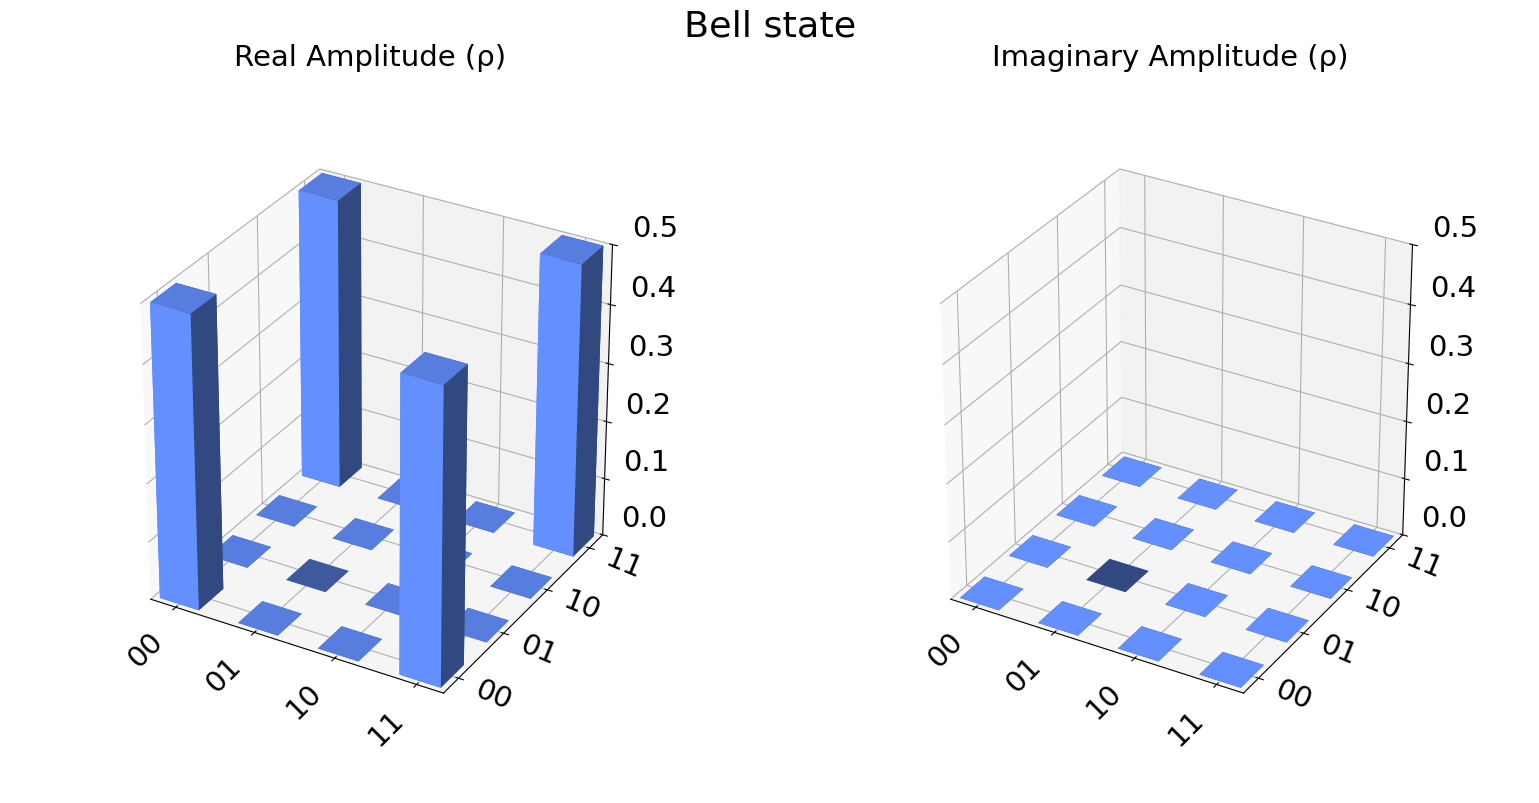

In [13]:
from qiskit.visualization import plot_state_city, plot_state_hinton, plot_state_qsphere, \
                                 plot_histogram

plot_state_city(state, title='Bell state')

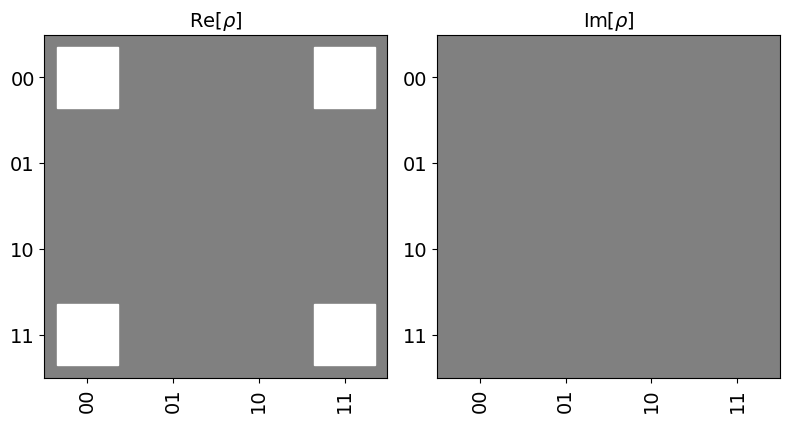

In [14]:
plot_state_hinton(state)

In [15]:
#seaborn package required
#plot_state_qsphere(state2)

**Simulate with Unitary simulator**

In [16]:
# Construct quantum circuit without measure
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.save_unitary()

# Run the quantum circuit on a unitary simulator backend
backend = AerSimulator(method = 'unitary')

# Create job and execute
job2 = backend.run(bell)
result2 = job2.result()

# Show the results
print(result2.get_unitary(bell, decimals=3))

Operator([[ 0.707+0.j,  0.707-0.j,  0.   +0.j,  0.   +0.j],
          [ 0.   +0.j,  0.   +0.j,  0.707+0.j, -0.707+0.j],
          [ 0.   +0.j,  0.   +0.j,  0.707+0.j,  0.707-0.j],
          [ 0.707+0.j, -0.707+0.j,  0.   +0.j,  0.   +0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


#### Simulate with Qasm simulator

Until now on, we simulated the quantum circuit. However in reality, we do not have direct access to the quantum state. Instead, each qubit should be *measured* at the end of the quantum circuit in specific basis (generally in the computational basis $|0\rangle, |1\rangle$). As soon as the quantum system is measured, the state $|\psi\rangle$ *collapses* to the measurement basis $|b\rangle$ with a probability :
$$
P(b) == |\langle b | \psi \rangle |^2.
$$
Unlike the previous steps, we need to add `ClassicalRegister` to measure the quantum circuit.
All customization here: https://qiskit.github.io/qiskit-aer/tutorials/1_aersimulator.html

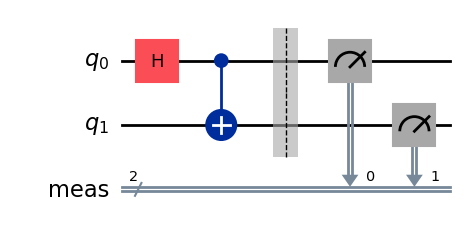

In [17]:
# Construct quantum circuit without measure
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
# Measure qubits
bell.measure_all()

bell.draw(output = 'mpl')

### ALL methods together
Simulation Method Option
The simulation method is set using the method kwarg. A list supported simulation methods can be returned using available_methods(), these are

1- `automatic`: Default simulation method. Select the simulation method automatically based on the circuit and noise model.

2 - `statevector`: A dense statevector simulation that can sample measurement outcomes from ideal circuits with all measurements at end of the circuit. For noisy simulations each shot samples a randomly sampled noisy circuit from the noise model.

3 - `density_matrix`: A dense density matrix simulation that may sample measurement outcomes from noisy circuits with all measurements at end of the circuit.

4 - `stabilizer`: An efficient Clifford stabilizer state simulator that can simulate noisy Clifford circuits if all errors in the noise model are also Clifford errors.

5 - `extended_stabilizer`: An approximate simulated for Clifford + T circuits based on a state decomposition into ranked-stabilizer state. The number of terms grows with the number of non-Clifford (T) gates.

6 - `matrix_product_state`: A tensor-network statevector simulator that uses a Matrix Product State (MPS) representation for the state. This can be done either with or without truncation of the MPS bond dimensions depending on the simulator options. The default behaviour is no truncation.

7 - `unitary`: A dense unitary matrix simulation of an ideal circuit. This simulates the unitary matrix of the circuit itself rather than the evolution of an initial quantum state. This method can only simulate gates, it does not support measurement, reset, or noise.

8 - `superop`: A dense superoperator matrix simulation of an ideal or noisy circuit. This simulates the superoperator matrix of the circuit itself rather than the evolution of an initial quantum state. This method can simulate ideal and noisy gates, and reset, but does not support measurement.

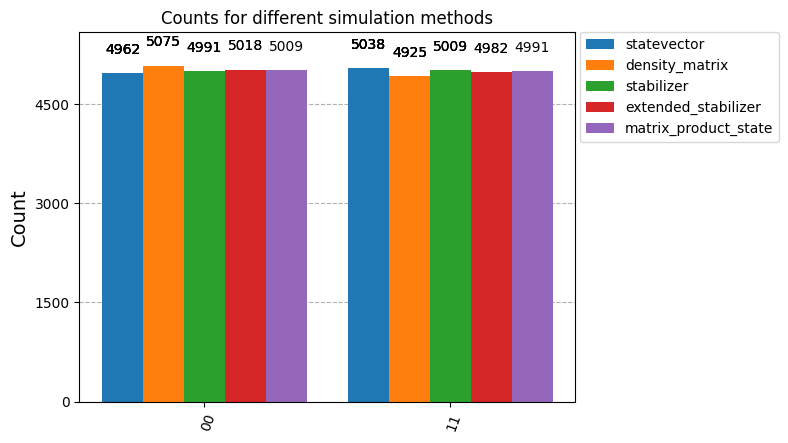

In [18]:
# Create circuit
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()


# Increase shots to reduce sampling variance
shots = 10000



# Statevector simulation method
sim_statevector = AerSimulator(method='statevector')
job_statevector = sim_statevector.run(circ, shots=shots)
counts_statevector = job_statevector.result().get_counts(0)

# Stabilizer simulation method
sim_stabilizer = AerSimulator(method='stabilizer')
job_stabilizer = sim_stabilizer.run(circ, shots=shots)
counts_stabilizer = job_stabilizer.result().get_counts(0)


# Extended Stabilizer method
sim_extstabilizer = AerSimulator(method='extended_stabilizer')
job_extstabilizer = sim_extstabilizer.run(circ, shots=shots)
counts_extstabilizer = job_extstabilizer.result().get_counts(0)

# Density Matrix simulation method
sim_density = AerSimulator(method='density_matrix')
job_density = sim_density.run(circ, shots=shots)
counts_density = job_density.result().get_counts(0)

# Matrix Product State simulation method
sim_mps = AerSimulator(method='matrix_product_state')
job_mps = sim_mps.run(circ, shots=shots)
counts_mps = job_mps.result().get_counts(0)


plot_histogram([ counts_statevector,counts_stabilizer ,counts_extstabilizer, counts_density, counts_mps],
               title='Counts for different simulation methods',
               legend=[ 'statevector',
                       'density_matrix','stabilizer','extended_stabilizer', 'matrix_product_state'])

#### Extra: some additional functions

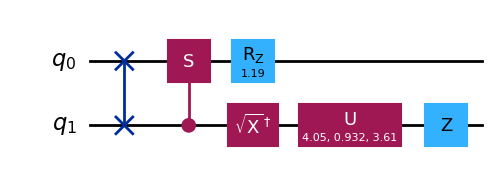

In [19]:
#Import the random circuit class
from qiskit.circuit.random import random_circuit
#Create two random circuits, each with 2 qubit registers and random #gate operator counts.
qc1 = random_circuit(2,2)
qc2 = random_circuit(2,4)
#Concatenate the two random circuits
qc = qc1.compose(qc2)
#Draw the circuit
qc.draw('mpl')

In [20]:
#Define function to print circuit properties:
def print_circuit_props(qc):
    width = qc.width()
    depth = qc.depth()
    num_operators = qc.count_ops()
    circuit_size = qc.size()
    print('Width = ',width) 
    print('Depth = ', depth)
    print('Circuit size = ',circuit_size)
    print('Number of operators = ', num_operators)

In [21]:
#Pass our quantum circuit to print out the circuit properties
print_circuit_props(qc)

Width =  2
Depth =  5
Circuit size =  6
Number of operators =  OrderedDict([('swap', 1), ('cs', 1), ('sxdg', 1), ('u', 1), ('rz', 1), ('z', 1)])


Width =  3
Depth =  1
Circuit size =  1
Number of operators =  OrderedDict([('ccx', 1)])


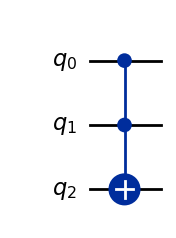

In [22]:
qc = QuantumCircuit(3)
qc.ccx(0,1,2)
#Print out the circuit properties
print_circuit_props(qc)
qc.draw('mpl')

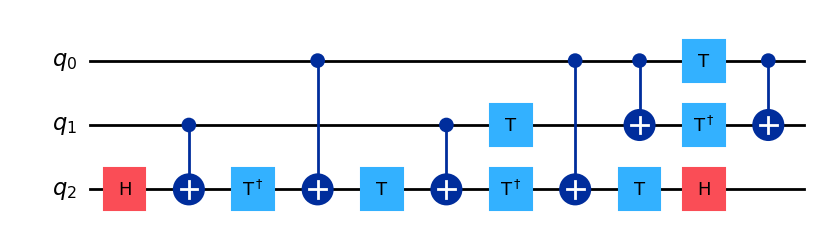

In [23]:
qc.decompose().draw('mpl')

In [24]:
#Print out the circuit properties
print_circuit_props(qc.decompose())

Width =  3
Depth =  11
Circuit size =  15
Number of operators =  OrderedDict([('cx', 6), ('t', 4), ('tdg', 3), ('h', 2)])


## 3. Basics of Quantum Mechanics on Gate-Based Circuits
In this section, we’ll dive deeper into the fundamental concepts of **pure states** and **mixed states**, how to work with them in code, and explore properties like **purity**, **entropy** and **partial trace**. We’ll also demonstrate how to verify if an operation is unitary.

### Overview of Quantum States

State-vector notation  is convenient when dealing with states that can always be expressed as a linear combination of basis states, each with an associated probability amplitude. The definition of the state of our qubits cannot always be written down as linear combinations in a given basis, sometimes it must be expressed in terms of ensembles (statistical mixtures) of multiple states (noise), each with an associated probability of occurrence. The adopted formulation is the `density matrix`. 
In the following we will review this formulation for ***pure state***, **mixed state** and we introduce the concept of **state purity** and ***partial trace***.

#### Pure State
Pure states are those for which we can precisely define their quantum state at every point in time and the measurement outcome will be probabilistic with no uncertainty on what this quantum state will be.
For example, if we initialize the single qubit $|q \rangle $ in state $ | 0 \rangle $, and apply a Hadamard gate, we know our final state will be:

$$ 
| q \rangle = \frac{1}{\sqrt{2}} \left( | 0 \rangle  + | 1 \rangle  \right) = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 1 \end{bmatrix} = | + \rangle 
$$
In general, we know that in the conventional state vector notation, an $n$-qubit pure state can be expressed as:

$$ | \psi \rangle = \begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \vdots \\ \alpha_{N-1} \end{bmatrix}, $$

where $ N = 2^{n} $. An alternative way to express this pure quantum state is in the form of a matrix. This can be done by using the density operator representation, which is defined as:

$$ \rho \equiv  | \psi \rangle \langle \psi | $$

Here, the term $| \psi \rangle \langle \psi | $ represents the [outer product](../ch-gates/proving-universality.ipynb#outer) of the state $ \psi $ with itself:


$$ 
\begin{aligned}
& \rho = \begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \vdots \\ \alpha_N \end{bmatrix} \begin{bmatrix} \alpha_0^* & \alpha_1^* & \dots & \alpha_N^* \end{bmatrix} 
\\
\\
& \rho = \begin{bmatrix} |\alpha_0|^2 & \alpha_0 \alpha_1^* & \dots & \alpha_0 \alpha_N^* \\ \alpha_1 \alpha_0^* & |\alpha_1|^2 & \dots & \alpha_1 \alpha_N^* \\ \vdots & \vdots & \ddots & \vdots \\ \alpha_N \alpha_0^* & \alpha_N \alpha_1^* & \dots & |\alpha_N|^2 \end{bmatrix}
\end{aligned}
$$


Let's consider, for example, the following two-qubit, maximally-entangled pure state:

$$ | \psi_{AB} \rangle = \frac{1}{\sqrt{2}} \left ( | 0 0 \rangle + | 1 1 \rangle \right ) = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 0 \\ 0 \\ 1 \end{bmatrix} 
$$


The density matrix representation for this state is then given by:

$$ 
\begin{aligned}
& \rho_{AB}  = | \psi_{AB} \rangle \langle \psi_{AB} |
\\
\\
& \rho_{AB} = \left ( \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 0 \\ 0 \\ 1 \end{bmatrix} \right ) \left ( \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 0 & 0 & 1 \end{bmatrix} \right )
\\
\\
& \rho_{AB} = \frac{1}{2} \begin{bmatrix} 1 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 1 & 0 & 0 & 1 \\ \end{bmatrix}
\end{aligned}
$$


In Qiskit, we can use the ``quantum_info`` module to represent quantum states either in state vector notation, or in the density matrix representation. For convenience, we will import this module as ``qi``:

In [25]:
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

Let's once again consider the entangled pure state $| \psi_{AB} \rangle $. We can prepare this state by applying a Hadamard gate to the first qubit, and an CNOT between the first and second qubits:

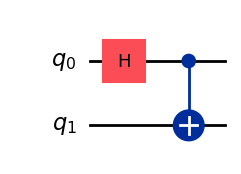

In [26]:
qc_AB = QuantumCircuit(2)
qc_AB.h(0)
qc_AB.cx(0,1)
qc_AB.draw('mpl')

To obtain the state constructed by our ``QuantumCircuit`` in state vector notation, we can make use of the ``Statevector.from_instruction()`` class method from the ``quantum_info`` module as follows:

In [27]:
psi_AB = qi.Statevector.from_instruction(qc_AB)
psi_AB.draw('latex', prefix='|\\psi_{AB}\\rangle = ')

<IPython.core.display.Latex object>

Similarly, we can use the ``DensityMatrix.from_instruction()`` class method to obtain density matrix representation for this same state:

In [28]:
rho_AB = qi.DensityMatrix.from_instruction(qc_AB)
rho_AB.draw('latex', prefix='\\rho_{AB} = ')

<IPython.core.display.Latex object>

### Mixed States <a id="mixed"></a>

Mixed states are those that consist of statistical ensembles of different quantum states.

Consider, once again, the two-qubit entangled state:

$$ | \psi_{AB} \rangle = \frac{1}{\sqrt{2}} \left ( | 0_A 0_B \rangle + | 1_A 1_B \rangle \right ) $$

Here we have explicitly used the subscripts $A$ and $B$ to label the qubits associated with registers $q_1$ and $q_0$, respectively. Now, let's assume that right after preparing our state $| \psi_{AB} \rangle $ we perform a measurement on register $q_1$.


We know that after a measurement, $\psi_B$ will be in state $| 0_B \rangle $ with probability $1/2$, or in state $| 1_B \rangle $ with probability $1/2$; however, $\psi_B$ is **not** in a linear superposition of $| 0_B \rangle $ and $| 1_B \rangle $. In other words, $\psi_B$ **cannot** be expressed as a state vector of the form $1/\sqrt{2} \left (|0_B \rangle + | 1_B \rangle \right)$. Instead, we have to use a different notation to write down that $\psi_B$ is rather an ensemble (not a quantum superposition) of the states $| 0_B \rangle $ and $| 1_B \rangle $, and whose outcome depends on what we measure on register $q_1$. 

We then call $\psi_B$ a mixed state, which can be represented as an ensemble of states:

$$
\left \{| \psi_{B_0} \rangle , | \psi_{B_1} \rangle \right \} = \left \{ | 0_B \rangle , | 1_B \rangle \right \},
$$ 

each with an associated probability of occurrence:

$$ \left \{ p_0, p_1 \right \} = \left \{ 1/2, 1/2 \right \} $$

Although this way of expressing $\psi_B$ (or any general mixed state) is perfectly valid, it turns out to be somewhat inconvenient. Since a mixed state can consist of a myriad of pure states, it can be difficult to track how the whole ensemble evolves when, for example, gates are applied to it. It is here that we turn to the density matrix representation.

A mixed state, consisting of several possible outcome pure states $|\psi_j \rangle$ , each with probability of occurrence $p_j$, is defined as a density matrix of the form:

$$ \rho \equiv \sum_{j} p_j |\psi_j \rangle \langle \psi_j | $$

It is easy to see that this general definition of the density matrix also holds for pure states, for which we will only have one $ |\psi_j \rangle $ term with $p_j = 1$.

#### Pure vs. Mixed States: Theory Recap

* Pure State: A state that can be represented by a single vector in a Hilbert space, often written as $|\psi\rangle$. The state is described completely by this vector, and its density matrix is $ \rho = | \psi \rangle \langle \psi | $, where $Tr (\rho^{2})=1 $.
* Mixed State: A statistical ensemble of pure states, described by a density matrix. Mixed states cannot be represented by a single vector, and their density matrices satisfy $Tr (\rho^{2})< 1 $.

#### Working with Pure and Mixed States in Code

First, let's create a pure state and a mixed state in Qiskit. Then, we’ll explore how to analyze their properties, including calculating the **entropy** and **partial trace**.

**Pure state example**
In this example, we’ll create a pure state using the Hadamard gate.

In [29]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, partial_trace, entropy, DensityMatrix

# Initialize a single-qubit pure state
pure_circuit = QuantumCircuit(1)
pure_circuit.h(0)  # Apply H-gate to create a superposition (pure state)
state = Statevector.from_instruction(pure_circuit)
print("Statevector for pure state:")
print(state)  # Should show a superposition state


Statevector for pure state:
Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


**Mixed State Example**

A mixed state can be created by preparing a system in different pure states probabilistically or by applying a random measurement.

In [30]:
# Define a circuit for a mixed state by resetting and measuring
mixed_circuit = QuantumCircuit(1)
mixed_circuit.h(0)
mixed_circuit.reset(0)  # Resetting qubit creates a probabilistic mixture

print("Density matrix for mixed state:")
print(DensityMatrix(mixed_circuit))

Density matrix for mixed state:
DensityMatrix([[1.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j]],
              dims=(2,))


**Measuring Properties of Pure and Mixed States**

Let’s calculate some key properties like **purity**, **entropy** and **partial trace** for both states.

### State Purity <a id="trace_sqr"></a>

A very useful property of the density matrix is that when taking the trace $\text{Tr}$ of its square $\rho^{2}$, we obtain a scalar value $\gamma$ that is good measure of the purity of the state the matrix represents. For normalized states, this value is always less than or equal to 1, with the equality occurring for the case of a pure state:

$$ \gamma \equiv \text{Tr}(\rho^{2}) \leq 1 $$

$$ \gamma \equiv \text{Tr}(\rho^{2}) = 1 \; \text{if pure} $$

In Qiskit, we can easily extract the purity of a density matrix by using the `purity()` class method. For example, for the pure state $| + \rangle$, we should expect to see a purity of 1:

In [31]:
import numpy as np
rho_p = qi.DensityMatrix.from_label('+')
display(rho_p.draw('latex', prefix='\\rho_p = '))
gamma_p = rho_p.purity()
print("State purity: ", np.round(np.real(gamma_p),3))

<IPython.core.display.Latex object>

State purity:  1.0


And, for a mixed state, like $\rho_m = \frac{1}{2} | 0 \rangle \langle 0 | + \frac{1}{2} | 1 \rangle \langle 1 | $, we expect a purity of less than 1:

In [32]:
rho_m = 1/2*(qi.DensityMatrix.from_label('0') + qi.DensityMatrix.from_label('1'))
display(rho_m.draw('latex', prefix='\\rho_m = '))
gamma_m = rho_m.purity()
print("State purity: ", np.round(np.real(gamma_m),3))

<IPython.core.display.Latex object>

State purity:  0.5


In [33]:
## or from the previous mixed state
display(DensityMatrix(mixed_circuit).draw('latex', prefix='\\rho_p = '))
DensityMatrix(mixed_circuit).purity()

<IPython.core.display.Latex object>

(0.9999999999999996+0j)

***NB*** One of the drawbacks of representing the density matrices in terms of ensembles of basis states, is that their outcome is not unique. Understanding that the same density matrix can represent many different ensembles of quantum states is important to avoid drawing conclusions about a particular system simply based on its density matrix representation alone. 

### The Reduced Density Matrix
When working with the density matrix notation on composite systems, we can extract the state of each subsystem, even if they are entangled. This is done in the form of what is known as the reduced density matrix.

Consider a quantum system composed of subsystems $A$ and $B$, and fully described by the density matrix $\rho_{AB}$. The reduced density matrix of subsystem $A$ is then given by:

$$ \rho_{A} = \text{Tr}_B(\rho_{AB}), $$


Here, $\text{Tr}_B$ is an operation known as the partial trace, which is defined as: 

$$
\text{Tr}_B \left (| \xi_u \rangle \langle \xi_v | \otimes | \chi_u \rangle \langle \chi_v | \right ) \equiv | \xi_u \rangle \langle \xi_v | \text{ Tr} \left ( | \chi_u \rangle \langle \chi_v | \right )
$$

$| \xi_u \rangle $ and $| \xi_v \rangle $ are arbitrary states in the subspace of $A$, and $| \chi_u \rangle $ and $| \chi_v \rangle $ arbitrary states in the subspace of $B$. $\text{Tr}$ is the standard trace operation, which for two arbitrary states $\text{Tr} \left ( | \chi_u \rangle \langle \chi_v | \right ) = \langle \chi_v |\chi_u \rangle $. Similarly, we can calculate the reduced density matrix of subsystem $B$ using the partial trace over $A$.

As an example, let's reconsider the pure entangled state:

$$ | \psi_{AB} \rangle = \frac{1}{\sqrt{2}} \left ( | 0_A 0_B \rangle + | 1_A 1_B \rangle \right ) $$




This system is then composed of single-qubit subsystem $A$ with basis vectors $ \left \{ |\xi_1 \rangle, |\xi_2 \rangle \right \} = \{ | 0_A \rangle, | 1_A \rangle \}$, and single-qubit subsystem $B$ with basis vectors $ \left \{ |\chi_1 \rangle, |\chi_2 \rangle \right \} = \{ | 0_B \rangle, | 1_B \rangle \}$. We know that this system is not separable (i.e., $| \chi_{AB} \rangle \neq |\chi_{A}\rangle \otimes |\chi_{B}\rangle$); however, by using the reduced density matrix, we can find a full description for subsystems $A$ and $B$ as follows.

The density matrix of our state $| \psi_{AB} \rangle$ can be expressed in terms of outer products of the basis vectors as:

$$
\rho_{AB} = | \psi_{AB} \rangle \langle \psi_{AB} | =  \frac{1}{2} \left [ | 0_A 0_B \rangle \langle 0_A 0_B | + | 0_A 0_B \rangle \langle 1_A 1_B | + | 1_A 1_B \rangle \langle 0_A 0_B | + | 1_A 1_B \rangle \langle 1_A 1_B | \right ]
$$


Now, to calculate the reduced density matrix for, let's say, subsystem $B$, we have:

$$
\begin{aligned}
\rho_{B} & = \text{Tr}_A(\rho_{AB})
\\
\\
& = \frac{1}{2}\left [ \text{Tr}_A(| 0_A 0_B \rangle \langle 0_A 0_B |) + \text{Tr}_A(| 0_A 0_B \rangle \langle 1_A 1_B |) + \text{Tr}_A(| 1_A 1_B \rangle \langle 0_A 0_B |) + \text{Tr}_A(| 1_A 1_B \rangle \langle 1_A 1_B |) \right ]
\\
\\
& = \frac{1}{2}\left [ \text{Tr}(| 0_A \rangle \langle 0_A |)| 0_B \rangle \langle 0_B | + \text{Tr}(| 0_A \rangle \langle 1_A |)| 0_B \rangle \langle 1_B | + \text{Tr}(| 1_A \rangle \langle 0_A |) | 1_B \rangle \langle 0_B | + \text{Tr}(| 1_A \rangle \langle 1_A |) | 1_B \rangle \langle 1_B | \right ]
\\
\\
& = \frac{1}{2}\left [ \langle 0_A | 0_A \rangle | 0_B \rangle \langle 0_B | + \langle 1_A | 0_A \rangle | 0_B \rangle \langle 1_B | + \langle 0_A | 1_A \rangle | 1_B \rangle \langle 0_B | + \langle 1_A | 1_A \rangle | 1_B \rangle \langle 1_B | \right ]
\\
\\
& = \frac{1}{2}\left [ | 0_B \rangle \langle 0_B | + | 1_B \rangle \langle 1_B | \right ]
\\
\\
&= \frac{1}{2} \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} 
\end{aligned}
$$



In [34]:
rho_B = qi.partial_trace(rho_AB,[0])
rho_A = qi.partial_trace(rho_AB,[1])

display(rho_B.draw('latex', prefix=" \\rho_{B} = "),
        rho_A.draw('latex', prefix=" \\rho_{A} = "))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [35]:
# Create a two-qubit entangled state (Bell state) for partial trace demonstration
entangled_circuit = QuantumCircuit(2)
entangled_circuit.h(0)
entangled_circuit.cx(0, 1)

# Get the statevector and compute partial trace to isolate one qubit
state = Statevector.from_instruction(entangled_circuit)
reduced_density_matrix = partial_trace(state, [1])
print("Reduced density matrix after tracing out one qubit:")
print(reduced_density_matrix)


Reduced density matrix after tracing out one qubit:
DensityMatrix([[0.5+0.j, 0. +0.j],
               [0. +0.j, 0.5+0.j]],
              dims=(2,))


**Entropy of a state** 
- Entropy is a measure of uncertainty. Pure states have zero entropy, while mixed states have non-zero entropy.

In [36]:
# Calculate entropy using Qiskit's entropy function
pure_entropy = entropy(state)
print("Entropy of pure state:", pure_entropy)

mixed_entropy = entropy(DensityMatrix(rho_m))
                        
print("Entropy of mixed state:", mixed_entropy)


Entropy of pure state: 0
Entropy of mixed state: 1.0


see here for all methods https://docs.quantum.ibm.com/api/qiskit/quantum_info

**Verifying Unitarity of Quantum Operations**

In quantum mechanics, a matrix is unitary if its inverse is equal to its conjugate transpose:
<n>$U^{\dagger}U =1 $ <n/>


We can check if a matrix is unitary by confirming that $U^{\dagger}U =1 $ is equal to the identity matrix.

In [37]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit.circuit.library import HGate

# Get the matrix representation of the Hadamard gate
h_gate = Operator(HGate()).data

# Calculate U† * U
unitarity_check = np.allclose(h_gate.conj().T @ h_gate, np.eye(2))

print("Matrix representation of the H gate:")
print(h_gate)

print("\nIs the H gate unitary?")
print(unitarity_check)  # Expected output: True


Matrix representation of the H gate:
[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]

Is the H gate unitary?
True


In [38]:
# Example with a non-unitary operator (like a measurement projector)
non_unitary_matrix = np.array([[1, 0], [0, 0]])  # Measurement projector
unitarity_check_non_unitary = np.allclose(non_unitary_matrix.conj().T @ non_unitary_matrix, np.eye(2))
print("Is the measurement projector unitary?", unitarity_check_non_unitary)

Is the measurement projector unitary? False


### Hands-On with PennyLane
**1. Verifying Unitarity in PennyLane** 


In [39]:
import pennylane as qml
from pennylane import numpy as np

# Retrieve the matrix representation of the Hadamard gate
h_gate_matrix = qml.matrix(qml.Hadamard(wires=0))

# Check unitarity: U† * U should be the identity matrix
unitarity_check = np.allclose(h_gate_matrix.conj().T @ h_gate_matrix, np.eye(2))

print("Matrix representation of the Hadamard gate:")
print(h_gate_matrix)

print("\nIs the Hadamard gate unitary?")
print(unitarity_check)  # Expected: True



Matrix representation of the Hadamard gate:
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

Is the Hadamard gate unitary?
True


**2. Mixed State Example with Entropy and Partial Trace**

Noise models such as depolarizing_error are not included in PennyLane's core. Instead, noise can be applied using the "default.mixed" device, which includes noise channels as part of the library. 

**Generating a Mixed State**

In [40]:
# Define a device that supports mixed states
dev = qml.device("default.mixed", wires=1)

@qml.qnode(dev)
def mixed_state_circuit():
    qml.Hadamard(wires=0)  # Create a superposition state
    qml.DepolarizingChannel(0.3, wires=0)  # Apply depolarizing noise
    return qml.density_matrix(wires=[0])

# Retrieve the density matrix
mixed_state = mixed_state_circuit()
print("Density matrix of the mixed state:")
print(mixed_state)


Density matrix of the mixed state:
[[0.5+0.j 0.3+0.j]
 [0.3+0.j 0.5+0.j]]


**Calculating the Entropy of the Mixed State**

Since PennyLane doesn’t have direct entropy and partial trace methods, we calculate them manually.

***Entropy Calculation (Von Neumann Entropy)***

The entropy $S(\rho) = - Tr(\rho \log \rho) $

In [41]:
# Calculate entropy of the mixed state
eigenvalues = np.linalg.eigvals(mixed_state)
entropy = -np.sum(eigenvalues * np.log2(eigenvalues + 1e-10))  # Avoid log(0) with small epsilon
print("\nEntropy of the mixed state:")
print(entropy)



Entropy of the mixed state:
(0.7219280945988189-0j)


**Partial Trace Calculation: Reducing a Composite State** 

Let’s calculate the partial trace of a two-qubit system to isolate one subsystem.

In [42]:
# Define a two-qubit device
dev = qml.device("default.mixed", wires=2)

@qml.qnode(dev)
def entangled_circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])  # Create an entangled Bell state
    return qml.density_matrix(wires=[0, 1])

dm_entangled = entangled_circuit()
print("\nDensity matrix of the entangled state:")
print(dm_entangled)

# Function to compute partial trace
def partial_trace(density_matrix, subsystem_dim):
    """
    Partial trace over the first subsystem.
    Assuming a 2x2 subsystem.
    """
    reduced_dm = np.zeros((2, 2), dtype=complex)
    for i in range(2):
        for j in range(2):
            reduced_dm[i, j] = density_matrix[i*subsystem_dim + j, i*subsystem_dim + j]
    return reduced_dm

# Partial trace to isolate one subsystem
reduced_dm = partial_trace(dm_entangled, subsystem_dim=2)
print("\nReduced density matrix after partial trace:")
print(reduced_dm)



Density matrix of the entangled state:
[[0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]]

Reduced density matrix after partial trace:
[[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]


#### Extra on observables and their properties

When we use ***commuting observables*** in quantum mechanics, it has several important consequences:

1. **Simultaneous Measurement**: Observables that commute can be measured simultaneously without affecting each other's outcomes. For example, if two observables A and B commute, measuring A does not disturb B and vice versa.
2. **Shared Eigenbasis**: Commuting observables share a common set of eigenstates. This means that there is a basis in which both observables are diagonal, simplifying the analysis and interpretation of the system.
3. **Compatibility of Observables**: In quantum mechanics, observables that commute are considered compatible, meaning their measurements are independent of the measurement order.

In `Qiskit` and `PennyLane`, we can test commutativity of observables by checking whether their commutator is zero. The commutator of two operators A and B is defined as:

$[A,B] = AB - BA $

If this commutator is zero, i.e. $AB=BA $ the operators commute.

***Example: Testing Commutativity of Pauli Operators***

Let's use the Pauli operators X, Y, and Z as our observables. We know that:

* Pauli X and Y do not commute: $[X,Y]\neq 0 $
* Pauli X and Z do not commute: $[X,Z]\neq 0 $
* Pauli Z and Z commute trivially with each other: $[Z,Z]\neq 0 $

  Here’s how to test for commutativity:


In [43]:
import numpy as np
from qiskit.quantum_info import Operator

# Define Pauli matrices
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Function to check commutativity
def is_commuting(A, B):
    commutator = np.dot(A, B) - np.dot(B, A)
    return np.allclose(commutator, np.zeros_like(commutator))

# Test commutativity between Pauli X and Y
print("Do X and Y commute?", is_commuting(X, Y))  # Expected: False

# Test commutativity between Pauli X and Z
print("Do X and Z commute?", is_commuting(X, Z))  # Expected: False

# Test commutativity between Pauli Z and Z
print("Do Z and Z commute?", is_commuting(Z, Z))  # Expected: True


Do X and Y commute? False
Do X and Z commute? False
Do Z and Z commute? True


**Measuring Commuting Observables Simultaneously**

When observables commute, we can measure them simultaneously on a shared eigenbasis. Let's look at an example using Qiskit where we set up a circuit with commuting observables, such as measuring Z on two different qubits.

***Example: Measuring Commuting Observables*** $ Z \otimes Z$

Measurement results for Z ⊗ Z observable:


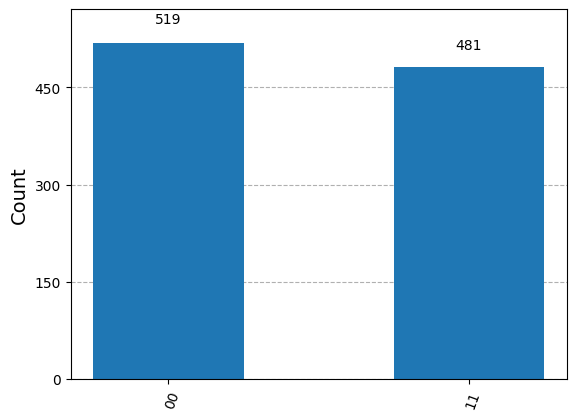

In [44]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram

# Create a 2-qubit circuit with Z-measurements on both qubits
qc = QuantumCircuit(2, 2)
qc.h(0)           # Create superposition on the first qubit
qc.cx(0, 1)       # Create entanglement between qubits
qc.measure([0, 1], [0, 1])  # Measure both qubits in the computational (Z) basis

# Simulate and visualize results
backend = AerSimulator(method = 'automatic')

job = backend.run(qc, shots=1000)
counts = job.result().get_counts(0)
print("Measurement results for Z ⊗ Z observable:")
plot_histogram(counts)


Since the `Z-measurements` on each qubit commute, we can measure them simultaneously and interpret the results. You should observe that outcomes are correlated, as the qubits share a common eigenbasis due to entanglement.

**Summary of Steps**

* Define Observables: Set up matrices or operators for the observables you want to test.
* Check Commutativity: Calculate the commutator between the observables and check if it’s zero.
* Measure Simultaneously (if Commuting): If observables commute, measure them on a shared eigenbasis in a quantum circuit and verify that the results align with the expected simultaneous measurement behavior.


This approach can be extended to larger systems and more complex observables.

### Extra: How to use Qiskit 1.0 with PennyLane

The PennyLane-Qiskit plugin enables you to integrate your existing Qiskit code and run circuits on IBM devices with PennyLane. See https://pennylane.ai/qml/demos/how_to_use_qiskit1_with_pennylane for further details.